In [228]:
using BenchmarkTools, LinearAlgebra, BandedMatrices, Polynomials, PyPlot
include("backsub.jl")
include("invBiU.jl")

BLAS.get_num_threads()

# BLAS.set_num_threads(8)
# BLAS.get_num_threads()


1

In [229]:
@benchmark BackSubVec(U, b);
@btime BackSubVec(U, b);

  4.702 μs (203 allocations: 11.17 KiB)


Matrix{Float64}
Matrix{Float64}
2.5638720017654315e-16
1.8539990263080453e-15
Matrix{Float64}
3.4247501166243157e-16
1.1954003836979178e-15
Matrix{Float64}
5.460715527308726e-16
1.3485002440826598e-15
Matrix{Float64}
6.362747579919083e-16
1.1696770532777972e-15
Matrix{Float64}
NaN
NaN
Matrix{Float64}
NaN
NaN
Matrix{Float64}
NaN
NaN
Matrix{Float64}
NaN
NaN
Matrix{Float64}
Matrix{Float64}
1.2509268882771003e-16
6.775030339033083e-16
Matrix{Float64}
2.4355418757871286e-16
8.811014626316532e-16
Matrix{Float64}
4.544445789632369e-16
1.292249545001302e-15
Matrix{Float64}
5.415021022533725e-16
9.989021629143552e-16
Matrix{Float64}
9.876234149277e-16
1.2387358832883377e-15
Matrix{Float64}
1.4806939513298683e-15
1.307560618602946e-15
Matrix{Float64}
1.799945465359274e-15
1.2023542159340953e-15
Matrix{Float64}
2.6029695220931157e-15
1.2150385549961943e-15


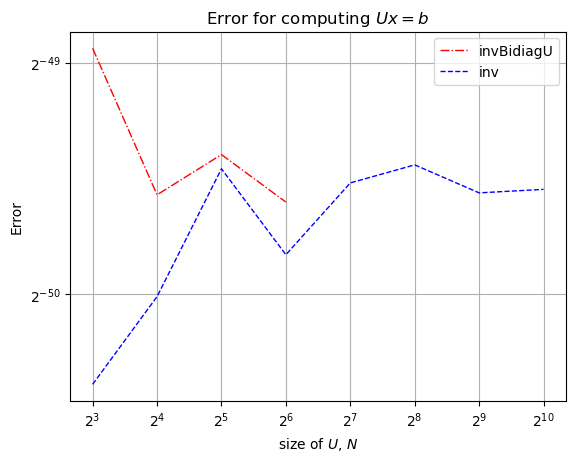

PyObject Text(0.5, 1.0, 'Error for computing $Ux=b$')

In [230]:

function getU(n, bᵤ, Utype="mat", elmtype="float")
    if Utype == "banded"
        if elmtype == "bigfloat"
            U = big.(BandedMatrix(rand(n, n), (0, bᵤ))) + 100*I
        else
            U = BandedMatrix(rand(n, n), (0, bᵤ)) + 100*I
        end
        println(typeof(U))
        return U
    end

    if elmtype == "bigfloat"
        U = big.(rand(n, n)) + 100*I
    else
        U = rand(n, n) + 100*I
    end

    if Utype == "bidiag" && bᵤ == 1
        U = Bidiagonal(U, :U)
    else
        U = triu(U) - triu(U, bᵤ+1) + 100*I
    end
    println(typeof(U))
    U;
end


function timer4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    BLAS.set_num_threads(nthreads)
    times4func = zeros(length(dims))
    for (i, n) in enumerate(dims)
        U = getU(n, bᵤ, Utype, elmtype)
        atime4func = 0.0
        for _ in 1:rept
            atime4func += @elapsed func(U)
        end
        times4func[i] = atime4func / rept
    end
    times4func;
end

function error4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    BLAS.set_num_threads(nthreads)
    A = getU(3, 1, Utype, elmtype)
    T = eltype(A)
    abserrors4func = zeros(T, length(dims))
    relerrors4func = zeros(T, length(dims))
    for (i, n) in enumerate(dims)
        U = getU(n, bᵤ, Utype, elmtype)
        x = rand(T, n)
        b = U * x
        abserr = zero(T)
        relerr = zero(T)
        for _ in 1:rept
            Uinv = func(U)
            x̂ = Uinv * b
            abserr += norm(x - x̂)
            relerr += abserr / norm(x)
        end
        abserrors4func[i] = convert(T, abserr / rept)
        relerrors4func[i] = convert(T, relerr / rept)
        println(abserrors4func[i])
        println(relerrors4func[i])
    end
    abserrors4func;
    relerrors4func;
end



function data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    # timeusage = zeros(length(funcs), length(dims))
    # for (i, func) in enumerate(funcs)
    #     timeusage[i, :] = timer4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    # end
    # timeusage;
    erroranalysis = zeros(length(funcs), length(dims))
    for (i, func) in enumerate(funcs)
        erroranalysis[i, :] = error4Uxb(func, dims, bᵤ, Utype, elmtype, rept, nthreads)
    end
    erroranalysis;
end


# timedata = data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)

# plot(timedata)
function plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    timedata = data4plot(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
    # println(timedata)
    colorlist = ["red", "blue", "green"]
    linestylelist = ["-.", "--"]
    figure()
    for (i, func) in enumerate(funcs)
        loglog(dims, timedata[i, :], color=colorlist[i], linewidth=1.0, linestyle=linestylelist[i], base=2, label=string(func))
        # plot(dims, timedata[i, :], color=colorlist[i], linewidth=1.0, linestyle=linestylelist[i], label=string(func))
    end
    xlabel(L"size of $U$, $N$")
    ylabel("Wall time")
    ylabel("Error")
    grid()
    legend()
    title(L"Time usage for computing $U^{-1}$")
    title(L"Error for computing $Ux=b$")
    # savefig("errors_inv_InvBiU", dpi=150)
    # sss = "11111"
    # xxx = "2222"
    # savefig("./figure/$sss.png", dpi=150)
    # savefig("./figure/$xxx.eps", format="eps")
end


function invBanded(U)
    qr(U) \ I
end

funcs = [invBidiagU, inv]
# funcs = [invBidiagU, invBanded]

dims = [2^i for i in 3:10]
bᵤ = 1
Utype = "mat"
# Utype = "bidiag"
# Utype = "banded"
# elmtype = "bigfloat"
elmtype = "float"
rept = 16
nthreads = 1

# "bidiag" "big" "banded"
# plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)
# elmtype = "bigfloat"
plot4data(funcs, dims, bᵤ, Utype, elmtype, rept, nthreads)

-8.47275e-6 - 4.44531e-7*x + 3.9775e-8*x^2
(-8.472753804647149e-6, -4.4453130907893845e-7, 3.977499864167876e-8)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


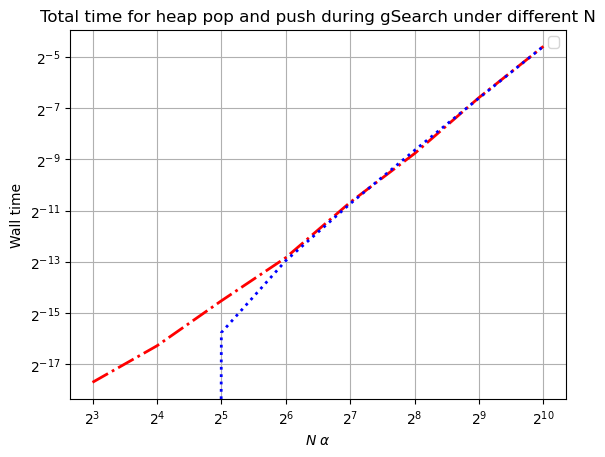

PyObject Text(0.5, 1.0, 'Total time for heap pop and push during gSearch under different N')

In [231]:
figure(1)
loglog(nlist, tk1, color="red", linewidth=2.0, linestyle="-.", base = 2)
# plot(nlist, tk1, color="red", linewidth=2.0, linestyle="-.")


fst = 1
lst = length(nlist)



# ploy1 = fit(nlist[fst:lst].*log2.(nlist[fst:lst]), tk1[fst:lst], 1)
# b1, a1 = ploy1.coeffs[1], ploy1.coeffs[2]
# println((a1, b1))

ploy2 = fit(nlist[fst:lst], tk1[fst:lst], 2)
println(ploy2)
c, b, a = ploy2.coeffs[1], ploy2.coeffs[2], ploy2.coeffs[3]

println((c, b, a ))





# loglog(nlist, a1.*nlist.*log2.(nlist).+b1, color="blue", linewidth=2.0, linestyle="dotted", base = 2)

# loglog(nlist, a1.*log2.(nlist).+b1, color="blue", linewidth=2.0, linestyle="dotted", base = 2)

loglog(nlist, a.*nlist.^2 .+ b.*nlist .+ c, color="blue", linewidth=2.0, linestyle="dotted", base = 2)
# plot(nlist, a.*nlist.^2 .+ b.*nlist .+ c, color="blue", linewidth=2.0, linestyle="dotted")

xlabel(L"$N$ $\alpha$")
ylabel("Wall time")
grid()
legend()
title("Total time for heap pop and push during gSearch under different N")


